In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from collections import Counter

%matplotlib inline

## Various functions to compute and process

In [2]:
def get_words_with_len(word_list, word_len):
    """ return a subset of the word_list matching word_len """
    return [word for word in word_list if len(word) == word_len]

In [3]:
# Frequency analysis of character appearance
def letter_frequency(word_list):
    """ Returns a dataframe sorted by the frequency distribution of letters in word_list """
    letter_list = [x for word in word_list for x in word]
    freq = Counter(letter_list)
    
    # Create the dataframe
    res = pd.DataFrame.from_dict(freq, orient='index', columns=['count']).sort_values('count', ascending=False)
    total_letters = res['count'].sum()
    res['freq'] = res['count'].apply(lambda x: (x / total_letters))
    
    return res

def position_frequency(word_list, pos):
    """ Returns a dataframe with position frequencies """
    res = None
    
    # Keep only words with len greater than pos (0-indexed)
    words = [word for word in word_list if len(word) > pos]
    letter_list = [word[pos] for word in words]
    
    freq = Counter(letter_list)
    
    # Create the dataframe
    res = pd.DataFrame.from_dict(freq, orient='index', columns=['count']).sort_values('count', ascending=False)
    total_letters = res['count'].sum()
    res[f'freq_pos{pos}'] = res['count'].apply(lambda x: (x / total_letters))
    res.drop('count', axis=1, inplace=True)
    return res

def wordle_frequencyDist(word_list, word_len=5):
    """ wrapper function that concats the overall frequency and positional frequencies """
    
    res = letter_frequency(word_list)
    
    for i in range(word_len):
        pos_df = position_frequency(word_list, i)
        res = pd.concat([res, pos_df], axis=1)
        
    return res

In [4]:
def get_optimum_word(word_list, explored_positions=None):
    """ docstring """
    
    if explored_positions is None:
        explored_positions = set()
        
    # confirm that all the words are of the same length
    assert len(set([len(x) for x in word_list])) == 1
    word_len = len(word_list[0])

    fdist = wordle_frequencyDist(word_list)
    
    cols = []
    for i in range(len(word_list[0])):
        if i not in explored_positions:
            cols.append(f'freq_pos{i}')
            
    pos_max_col = fdist.loc[:,cols].max().idxmax() # column with the maximum distribution
    pos_max_idx = fdist.loc[:,pos_max_col].idxmax() # actual alphabet
    pos_max_val = fdist.loc[:,pos_max_col].max() # frequency
    # print(pos_max_col, pos_max_idx, pos_max_val)
    
    # filter the word list to meet the optimum frequency and position
    pos = int(pos_max_col.split('freq_pos')[-1])
    optimum_words = [w for w in word_list if w[pos] == pos_max_idx]
    explored_positions.add(pos)
    
    # print(f'Position: {pos}')
    # print(optimum_words[:10])
    # print()
    
    if len(explored_positions) < word_len:
        res = get_optimum_word(optimum_words, explored_positions=explored_positions)
        res.extend(optimum_words)
        return res
    else:
        res = optimum_words
        return res

In [5]:
# Maximize tries by eliminating repeated characters in the first few tries
def only_unique_letters(word_list):
    # confirm that all the words are of the same length
    assert len(set([len(x) for x in word_list])) == 1
    word_len = len(word_list[0])
    
    return [w for w in word_list if len(set(list(w))) == len(w)]


# Use the feedback to reduce the original word list and repeat
def filter_words(word_list, exclude_letters, include_letters=None, correct_pos=None, wrong_pos=None ):
    res = word_list
    for a in exclude_letters:
        res = [w for w in res if a not in w]
        
    if include_letters is not None:
        for a in include_letters:
            res = [w for w in res if a in w]
            
    if correct_pos is not None:
        for pos, letter in correct_pos.items():
            res = [w for w in res if w[pos] == letter]
    
    if wrong_pos is not None:
        for pos, letter in wrong_pos.items():
            res = [w for w in res if w[pos] not in letter]

    return res

## Load word list

In [6]:
# Load all words first
with open('words_alpha.txt', 'r') as f:
    words_all = f.readlines()
    words_all = [x.lower().strip() for x in words_all]

# Filter to only 5 characters
words_5 = get_words_with_len(words_all, 5)
print(f'{len(words_5):,} game words loaded')

15,918 game words loaded


Text(0.5, 0, 'alphabet')

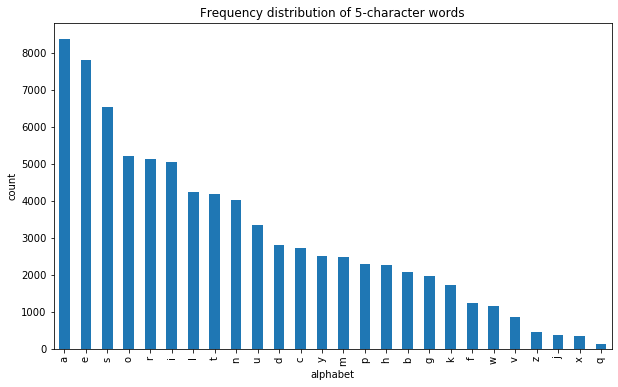

In [7]:
letter_frequency(words_5)['count'].plot(kind='bar', figsize=[10,6])
plt.title('Frequency distribution of 5-character words')
plt.ylabel('count')
plt.xlabel('alphabet')

In [8]:
wordle_frequencyDist(words_5)

,count,freq,freq_pos0,freq_pos1,freq_pos2,freq_pos3,freq_pos4
a,8392,0.105440,0.073690,0.180362,0.093039,0.099573,0.080538
e,7800,0.098002,0.026448,0.123759,0.064518,0.157620,0.117666
s,6537,0.082133,0.113896,0.010868,0.042845,0.045295,0.197764
o,5219,0.065574,0.020983,0.143297,0.072497,0.056728,0.034364
r,5143,0.064619,0.042782,0.072308,0.096997,0.054781,0.056226
i,5067,0.063664,0.018909,0.104850,0.079595,0.082988,0.031976
l,4246,0.053348,0.042656,0.054404,0.066591,0.057985,0.045106
t,4189,0.052632,0.061628,0.019852,0.049190,0.064016,0.068476
n,4043,0.050798,0.025443,0.034992,0.077774,0.058676,0.057105
u,3361,0.042229,0.020606,0.088139,0.049441,0.043096,0.009863


In [9]:
fdist = wordle_frequencyDist(words_5)
pos_max_col = fdist.loc[:,'freq_pos0':'freq_pos4'].max().idxmax() # column with the maximum distribution
pos_max_idx = fdist.loc[:,pos_max_col].idxmax() # actual alphabet
pos_max_val = fdist.loc[:,pos_max_col].max() # frequency

fdist.loc[:,'freq_pos0':'freq_pos4'].max()

freq_pos0    0.113896
freq_pos1    0.180362
freq_pos2    0.096997
freq_pos3    0.157620
freq_pos4    0.197764
dtype: float64

In [10]:
non_repeat_words = only_unique_letters(words_5)
guess = get_optimum_word(non_repeat_words)[0]
print(guess)

bares


In [11]:
exclude_letters = []
include_letters = []
correct_pos = defaultdict(str)
wrong_pos = defaultdict(list)

In [ ]:
ATTEMPTS = 6
for tries in range(ATTEMPTS-1): # We have already tried the first word
    outcome = input('What was the outcome? ')
    if outcome == 'ccccc':
        print('CONGRATULATIONS!')
        exit(0)
    
    for i, result in enumerate(outcome):
        if result == 'x':
            exclude_letters.append(guess[i])
        elif result == 'c':
            include_letters.append(guess[i])
            correct_pos[i] = guess[i]
        elif result == 'o':
            include_letters.append(guess[i])
            wrong_pos[i].append(guess[i])

        include_letters = set(include_letters)
        exclude_letters = set(exclude_letters)
        exclude_letters = exclude_letters.difference(include_letters)
        include_letters = list(include_letters)
        exclude_letters = list(exclude_letters)
        
    remaining_words = filter_words(
        words_5, 
        exclude_letters=exclude_letters, 
        include_letters=include_letters,
        correct_pos=correct_pos,
        wrong_pos=wrong_pos)
    
    if tries < 1:
        remaining_words = only_unique_letters(remaining_words)
    
    guesses = get_optimum_word(remaining_words)[:10]
    print(f'{len(remaining_words):,} words remaining')
    print(f'Try {guesses}')
    guess = input('Which word did you try? ')

What was the outcome? xxxcx
308 words remaining
Try ['coyed', 'coyed', 'coked', 'coned', 'coped', 'coted', 'coved', 'cowed', 'coxed', 'cozed']
Which word did you try? coyed
What was the outcome? xcxco
12 words remaining
Try ['modem', 'model', 'modem', 'godet', 'jodel', 'loden', 'model', 'modem', 'podex', 'woden']
Which word did you try? modem
What was the outcome? ccccx
2 words remaining
Try ['modem', 'model', 'modem', 'model', 'modem', 'model', 'modem', 'model', 'modem']
